# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [2]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# Let's see some data
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [3]:
# Check data_type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null object
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [4]:
df.describe()

,Data_Value
count,165085.000000
mean,95.422116
std,123.515131
min,-343.000000
25%,0.000000
50%,94.000000
75%,189.000000
max,406.000000


In [5]:
import numpy as np
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# Convert to celsius scale
df['Data_Value'] = df['Data_Value'] / 10

# Cast Date to Date time
df['Date'] = pd.to_datetime(df['Date'])

needed_columns = ['Date','Data_Value']

"""
Process min_df
"""

min_df = (df[df['Element'] == 'TMIN'][needed_columns]
            .where((df['Date'].dt.year >= 2005) & (df['Date'].dt.year < 2015))
            .dropna()
            .set_index('Date')
            .groupby(lambda dt: dt.strftime('%m-%d'))
            .agg({'Data_Value':np.min})
            .rename(columns={'Data_Value':'Min Temp'}))

min_df = min_df[min_df.index != '02-29']

print(f'Min Date for Min temps: {min_df.index.min()}')
print(f'Max Date for Min temps: {min_df.index.max()}')
print(f'Len of Min temps: {len(min_df)}')

"""
Process max_df
"""

max_df = (df[df['Element'] == 'TMAX'][needed_columns]
            .where((df['Date'].dt.year >= 2005) & (df['Date'].dt.year < 2015))
            .dropna()
            .set_index('Date')
            .groupby(lambda dt: dt.strftime('%m-%d'))
            .agg({'Data_Value':np.max})
            .rename(columns={'Data_Value':'Max Temp'}))

max_df = max_df[max_df.index != '02-29']
print(f'Min Date for Max temps: {max_df.index.min()}')
print(f'Max Date for Max temps: {max_df.index.max()}')
print(f'Len of Max temps: {len(max_df)}')

Min Date for Min temps: 01-01
Max Date for Min temps: 12-31
Len of Min temps: 365
Min Date for Max temps: 01-01
Max Date for Max temps: 12-31
Len of Max temps: 365


In [6]:
"""
Merge min and max df
"""
merged_df = min_df.join(max_df).sort_index()
merged_df.head()

,Min Temp,Max Temp
01-01,-16.0,15.6
01-02,-26.7,13.9
01-03,-26.7,13.3
01-04,-26.1,10.6
01-05,-15.0,12.8


In [7]:
"""
Process record breaker of 2015
"""

record_breaker = df[(df['Date'].dt.year == 2015)]

record_breaker['month-day'] = record_breaker['Date'].apply(lambda dt: dt.strftime('%m-%d'))

record_breaker = record_breaker.merge(merged_df,right_index=True,left_on='month-day')
record_breaker_low = record_breaker[record_breaker['Data_Value'] < record_breaker['Min Temp']]
record_breaker_high = record_breaker[record_breaker['Data_Value'] > record_breaker['Max Temp']]


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
len(record_breaker_low)

174

In [9]:
len(record_breaker_high)

192

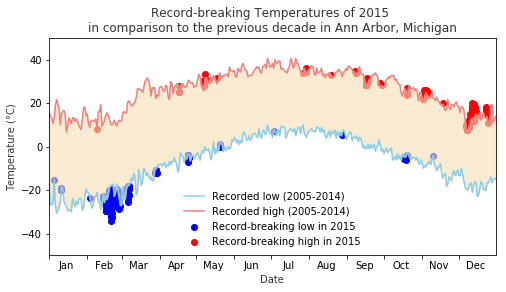

In [23]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

dates = pd.to_datetime('2015-'+max_df.index)
fig = plt.figure(figsize=(8,4))

ax = plt.gca()

# Limit axis values
ax.axis([pd.Timestamp(2015,1,1),pd.Timestamp(2015,12,31),-50,50])

# Plot recorded lows and highs from 2005-2014
ax.plot('2015-'+merged_df.index,merged_df['Min Temp'],c='skyblue',linewidth=1.5,label='Recorded low (2005-2014)')
ax.plot('2015-'+merged_df.index,merged_df['Max Temp'],c='lightcoral',linewidth=1.5,label='Recorded high (2005-2014)')

# Scatter plot the record-breakers of 2015
ax.scatter(record_breaker_low['Date'].values,record_breaker_low['Data_Value'].values,label='Record-breaking low in 2015',color='blue')
ax.scatter(record_breaker_high['Date'].values,record_breaker_high['Data_Value'].values,label='Record-breaking high in 2015',color='red')

# Shade the area between recorded lows and recorded highs of 2005-2014
ax.fill_between('2015-'+merged_df.index,merged_df['Min Temp'],merged_df['Max Temp'],color='wheat',alpha=0.6)

# Set titles,axis labels,legend
ax.set_title('Record-breaking Temperatures of 2015 \nin comparison to the previous decade in Ann Arbor, Michigan',alpha=0.8)
ax.set_xlabel('Date',alpha=0.8)
ax.set_ylabel('Temperature (°C)',alpha=0.8)
plt.legend(frameon=False)

# Modify the major and minor 
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Remove smaller ticks
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
    
plt.savefig('Assignment2.png')